In [1]:
import os, sys
import numpy as np
import pandas as pd
import EMdata
import torch
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [3]:
#data path
file_path='F:/script/class2vec/real_star_file/10340_case2_600_sampling4.star'
datatype=0 #0 is relion 3.1, 1 is relion 3
df=True
block_size=64
file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [4]:
%%time
if df:
    file_info=EMdata.read_data_df(file_path)
    dataframe=file_info.star2dataframe()
    metadata=dataframe.columns
    corpus_information=EMdata.process_helical_df(dataframe).extract_helical_select()
else:
    if datatype<2:
        file_info=EMdata.read_relion(file_path)
        if datatype==0:
            #read data (relion3.1)
            dataset=file_info.getRdata_31()
            optics=file_info.extractoptic()
        else:
            #read relion 3.0
            dataset=file_info.getRdata()
        metadata=dataset[0]
        print(metadata)
        data=dataset[1]
        print(data[0])
        #corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
        #label_path='F:/script/class2vec/real_star_file/self_unsupervised/10230_485_ctf/custom_single/pretext/'
        #label=np.load(label_path+'/classes_KM.npy')
        corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
print(corpus[0])
corpus_backup=corpus[:]

The filament number are:  5825
The number of particles are: 150601
0 0.07807836929957072 mins
10000 0.10073793331782023 mins
20000 0.12323032220204672 mins
30000 0.14576869010925292 mins
40000 0.1684333841005961 mins
50000 0.1909416158994039 mins
60000 0.21301191647847492 mins
70000 0.23589357535044353 mins
80000 0.2584259033203125 mins
90000 0.28107167879740397 mins
100000 0.3038061539332072 mins
110000 0.3265420158704122 mins
120000 0.34866859118143717 mins
130000 0.37166426579157513 mins
140000 0.395129398504893 mins
150000 0.4181167682011922 mins
finish converting
[(33, 1, 32) (33, 2, 33) (33, 3, 34) (27, 4, 35)]
[(28,  1,  75) (30,  2,  76) (30,  3,  77) (19,  4,  78) (34,  5,  79)
 (32,  6,  80) ( 1,  7,  81) ( 5,  8,  82) ( 5,  9,  83) ( 5, 10,  84)
 (39, 11,  85) (39, 12,  86) (13, 13,  87) (17, 14,  88) (17, 15,  89)
 (53, 16,  90) (46, 17,  91) (21, 18,  92) (21, 19,  93) (21, 20,  94)
 (21, 21,  95) (21, 22,  96) (14, 23,  97) (14, 24,  98) (45, 25,  99)
 (45, 26, 100) (45, 

In [5]:
# cryosparc
#corpus_ignore=corpus

In [6]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(str(particle[0]))
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(str(particle[0]))
                    count+=1
                    break
                corpus_row+=['0']
                count+=1               
    corpus_ignore.append(corpus_row)

In [7]:
#corpus_ignore=corpus
print(corpus_ignore[0])

['33', '33', '33', '27']


120


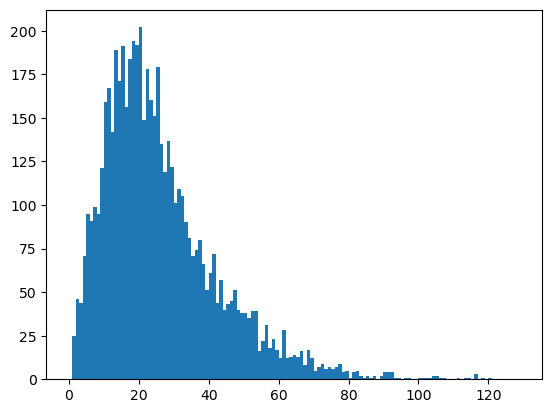

In [8]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
plt.hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
#plt.ylim((0,1000))
print(max(corpus_length_histogram))
plt.show()

In [9]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

54


In [10]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [11]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
if os.path.isdir(output_path+"/corpus") is False:
    os.mkdir(output_path+"/corpus")
paths = [str(x) for x in Path(output_path+"/corpus/").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=vocabulary_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
if os.path.isdir(output_path+"/tokens") is False:
    os.mkdir(output_path+"/tokens")
if os.path.isdir("./tokens") is False:
    os.mkdir("./tokens")
tokenizer.save_model(output_path+"/tokens")
tokenizer.save_model("./tokens")

['./tokens\\vocab.json', './tokens\\merges.txt']

In [12]:
import json

with open(output_path+'/tokens/vocab.json') as f:
    decode = json.load(f)
encode={value:key for (key, value) in decode.items()}


In [13]:
corpus_code=[]
for i in range(len(corpus_ignore)):
    lst=corpus_ignore[i]
    corpus_row=[]
    for j in range(len(lst)):
        corpus_row.append(encode[word_to_index[lst[j]]+5])
    corpus_code.append(corpus_row)

In [14]:
lst[j]

'53'

In [15]:
with open(output_path+"/corpus/helical.txt","w") as f:
    for i in range(len(corpus_code)):
        lst=corpus_code[i]
        for j in range(len(lst)):
            if j==len(lst)-1:
                f.write(lst[j]+'\n')
            else:
                f.write(lst[j])

In [16]:
if '0' in [i for i in vocabulary]:
    del decode[encode[word_to_index['0']+5]]
    print('delete the ignored group',print(encode[word_to_index['0']+5]))
with open('./tokens/vocab.json','w') as f:
    json.dump(decode,f)
with open(output_path+'/tokens/vocab.json','w') as f:
    json.dump(decode,f)

In [17]:
from transformers import RobertaTokenizerFast, BartTokenizer

tokenizer = BartTokenizer.from_pretrained(output_path+"/tokens", max_len=514)
#tokenizer.encode(encode[word_to_index['0']+5])

In [18]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=12,
    type_vocab_size=1,
    position_embedding_type=None
)

In [19]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [20]:
%%time
from transformers import LineByLineTextDataset

data_import = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=output_path+"/corpus/helical.txt",
    block_size=block_size,
)

D:\ProgramData\Anaconda3\lib\site-packages\transformers\data\datasets\language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


Wall time: 3.64 s


In [21]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [22]:
from transformers import Trainer, TrainingArguments


trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=data_import
)

In [23]:
trainer.train()

D:\ProgramData\Anaconda3\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5825
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2187


Step,Training Loss
500,4.700300
1000,3.915900
1500,3.834700
2000,3.691500


Saving model checkpoint to tmp_trainer\checkpoint-500
Configuration saved in tmp_trainer\checkpoint-500\config.json
Model weights saved in tmp_trainer\checkpoint-500\pytorch_model.bin
Saving model checkpoint to tmp_trainer\checkpoint-1000
Configuration saved in tmp_trainer\checkpoint-1000\config.json
Model weights saved in tmp_trainer\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to tmp_trainer\checkpoint-1500
Configuration saved in tmp_trainer\checkpoint-1500\config.json
Model weights saved in tmp_trainer\checkpoint-1500\pytorch_model.bin
Saving model checkpoint to tmp_trainer\checkpoint-2000
Configuration saved in tmp_trainer\checkpoint-2000\config.json
Model weights saved in tmp_trainer\checkpoint-2000\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2187, training_loss=4.003214574045496, metrics={'train_runtime': 210.0854, 'train_samples_per_second': 83.18, 'train_steps_per_second': 10.41, 'total_flos': 464037366513120.0, 'train_loss': 4.003214574045496, 'epoch': 3.0})

In [24]:
trainer.save_model(output_path+"/tokens/")
trainer.save_model("./tokens/")

Saving model checkpoint to F:/script/class2vec/real_star_file/10340_case2_600_sampling4/tokens/
Configuration saved in F:/script/class2vec/real_star_file/10340_case2_600_sampling4/tokens/config.json
Model weights saved in F:/script/class2vec/real_star_file/10340_case2_600_sampling4/tokens/pytorch_model.bin
Saving model checkpoint to ./tokens/
Configuration saved in ./tokens/config.json
Model weights saved in ./tokens/pytorch_model.bin


In [25]:
from transformers import pipeline

feature_extraction = pipeline(
    'feature-extraction',model="./tokens",tokenizer="./tokens")

loading configuration file ./tokens\config.json
Model config RobertaConfig {
  "_name_or_path": "./tokens",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 128,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": null,
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50000
}

loading configuration file ./tokens\config.json
Model config RobertaConfig {
  "_name_or_path": "./tokens",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_

In [26]:
#print(np.shape(feature_extraction(encode[word_to_index['50']+5])))
#print(np.squeeze(feature_extraction('DGG'))[0]-np.squeeze(feature_extraction('JJ'))[0])
print(len(''.join(corpus_code[2])))
print(len(corpus_ignore[2]))

30
30


In [27]:
def cut_corpus(corpus,cut_length):
    cut_index=[]
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<=cut_length:
            new_corpus.append(lst)
            continue
        if n%cut_length==0:
            cut_amount=int(n/cut_length)
        else:
            cut_amount=int((n-n%cut_length)/cut_length)+1
        for j in range(cut_amount-1):
            cut_index.append(i)
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus,cut_index
corpus_code_cut,cut_index=cut_corpus(corpus_code,block_size-2)

5825
6037


In [28]:
filament_embeddings=[]
for i in range(len(corpus_code_cut)):
    if i%200==0:
        print(i)
    lst=list(np.squeeze(feature_extraction(''.join(corpus_code_cut[i])))[0])
    filament_embeddings.append(lst)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000


In [29]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [30]:
filament_embeddings=np.array(filament_embeddings)
mask_1 = np.isfinite(filament_embeddings).all(axis=1)

In [31]:
len(filament_embeddings[mask_1])

6037

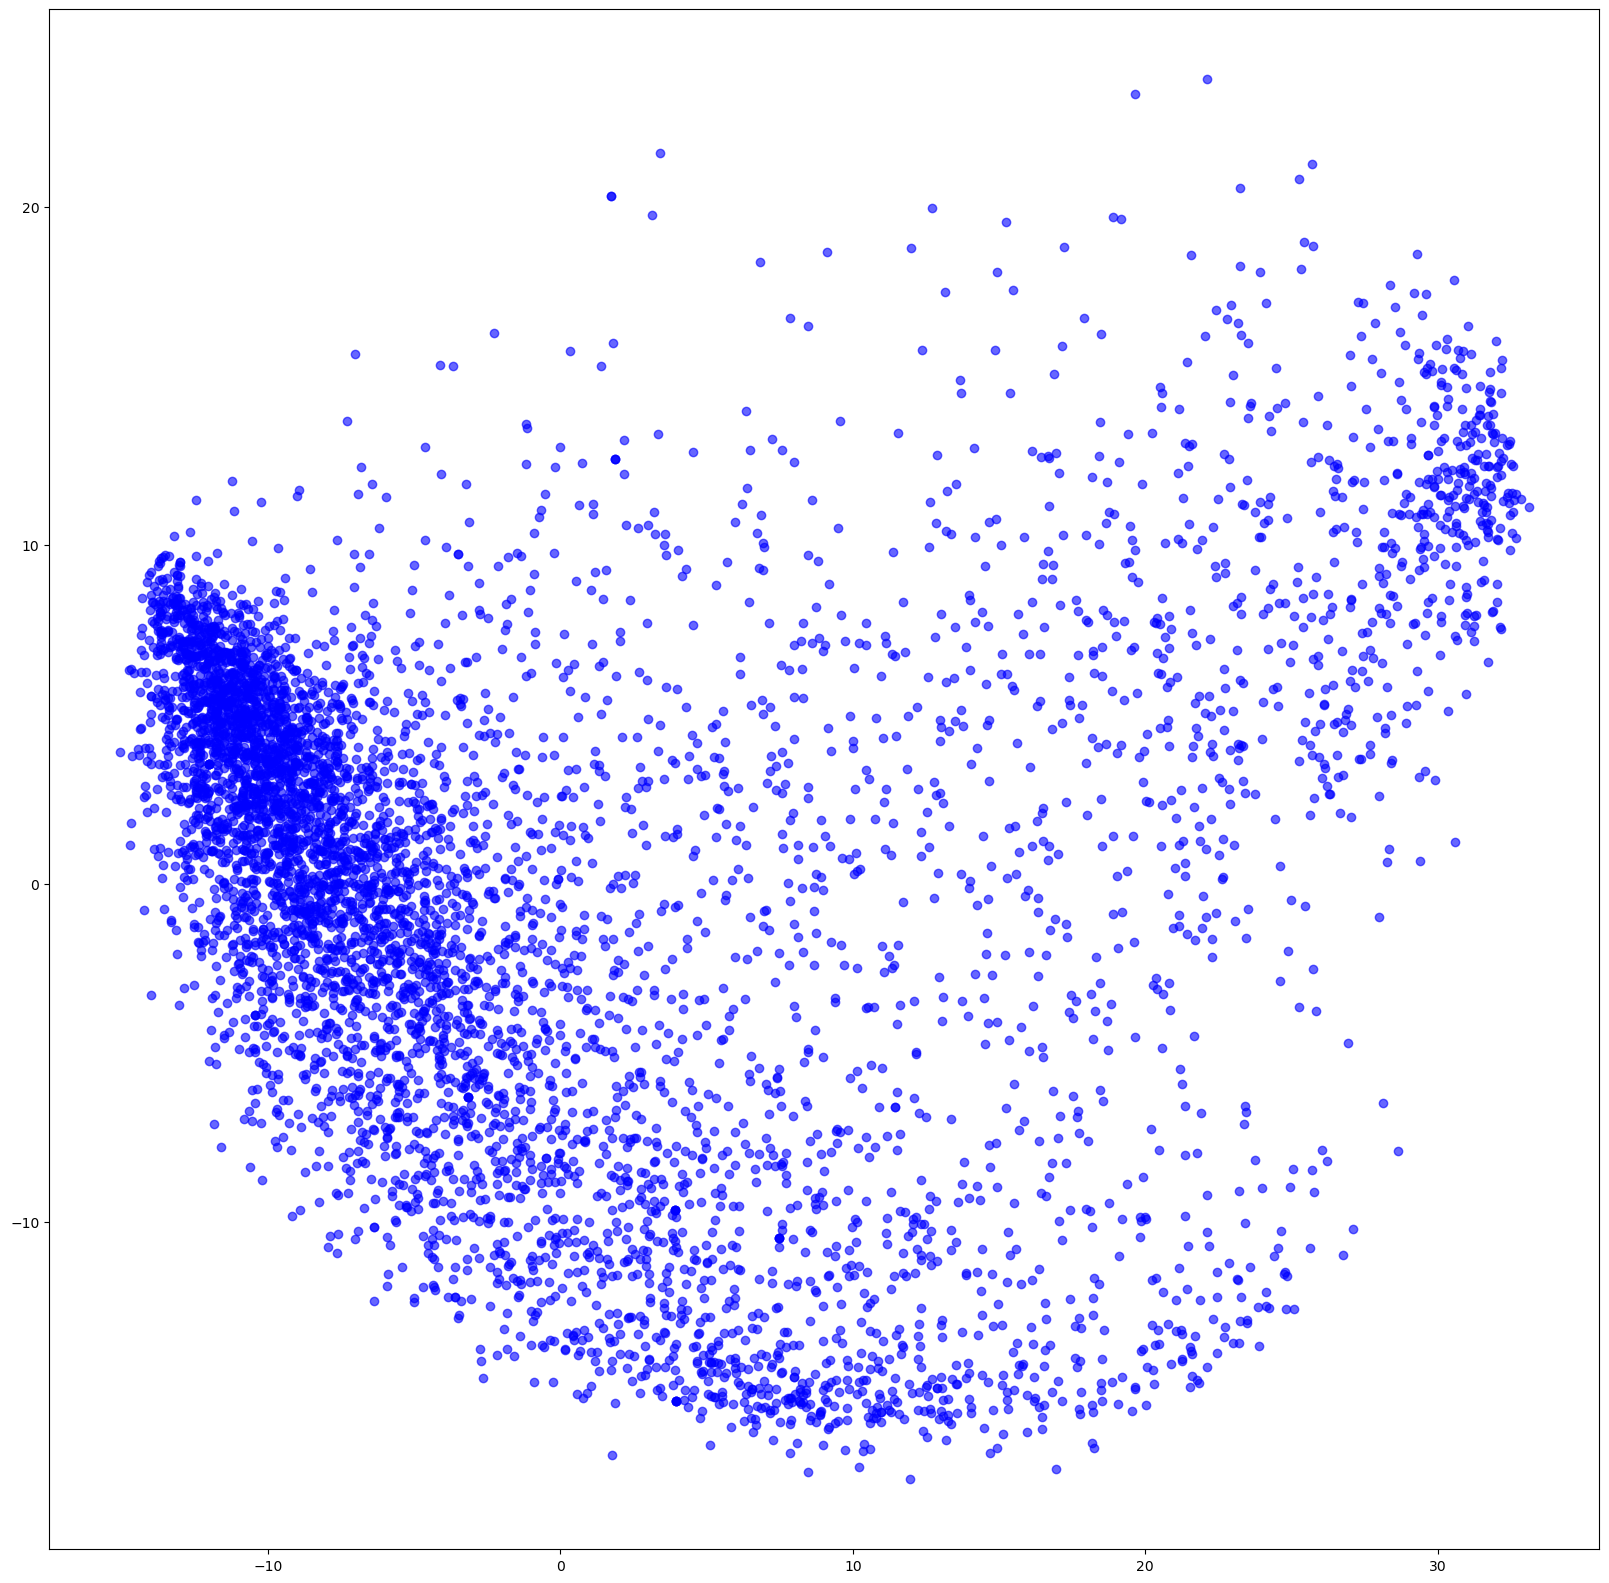

In [32]:
pca_sum = PCA(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
pca_sum_hD = PCA(n_components=30).fit_transform(filament_embeddings)

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [33]:
%%time
n_neighbors=100
min_dist=0.1
#umap_ND=umap.UMAP(n_neighbors=200,min_dist=0.4,n_components=100).fit_transform(filament_embeddings)
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(filament_embeddings)
umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=100).fit_transform(filament_embeddings)
print('finish umap')

finish umap
Wall time: 4min 19s


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


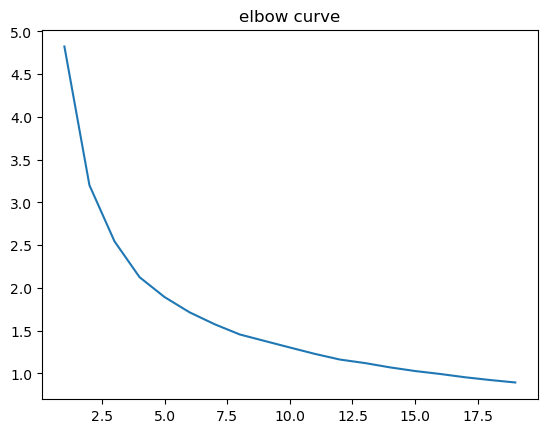

In [34]:
res = []
n_cluster = range(1,20)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(umap_ND)
    res.append(np.average(np.min(cdist(umap_ND, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

2
3
4
5
6
7
[0.47032267, 0.42228174, 0.42531997, 0.3926946, 0.4089166, 0.40539783]


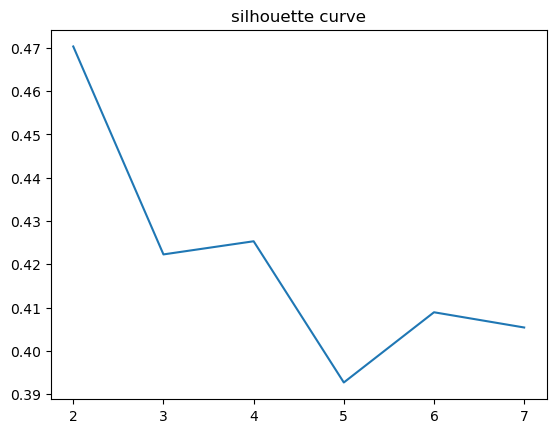

In [35]:
res=[]
n_cluster = range(2,8)
for i in n_cluster:
    print(i)
    kmeans_model = KMeans(n_clusters=i).fit(umap_2D)
    labels = kmeans_model.labels_
    a=metrics.silhouette_score(umap_ND, labels, metric='euclidean')
    res.append(a)

plt.plot(n_cluster, res)
print(res)
plt.title('silhouette curve')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_silhouette.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [36]:
filament_cluster_number=res.index(max(res[1:]))+2
#filament_cluster_number=5
#print(filament_cluster_number)
umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=DBSCAN(eps=0.35, min_samples=400).fit_predict(umap_2D)+1
#filament_cluster_number=len(np.unique(umap_predict))
print(filament_cluster_number)

4


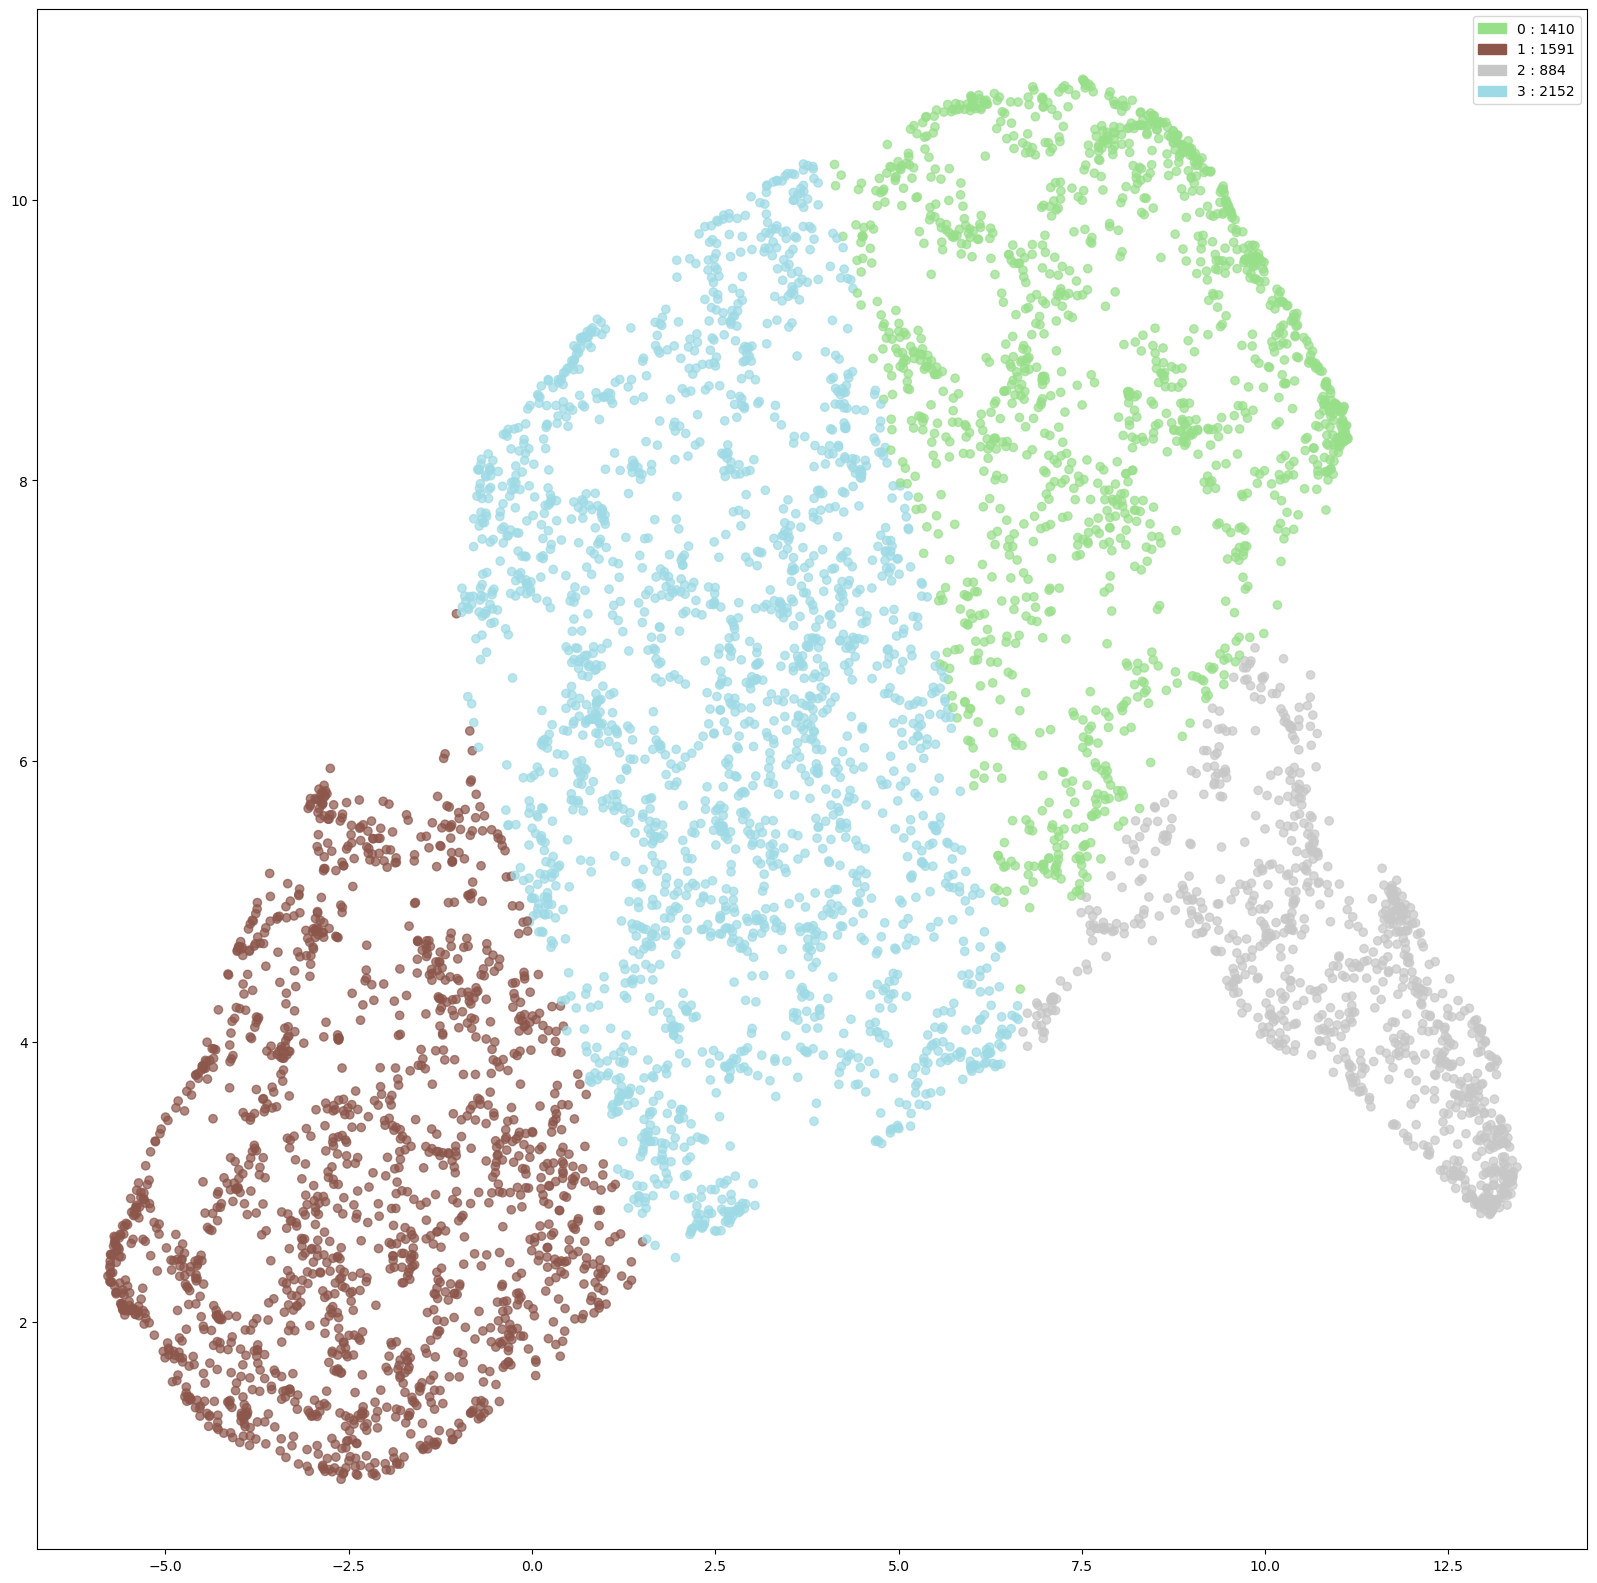

In [37]:
plt.figure(figsize = (20, 20))

for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), 
                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.7,c=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
#plt.xlim((-5,10))
#plt.ylim((-10,6))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_np.png",bbox_inches='tight', pad_inches=0.01)
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
plt.show()

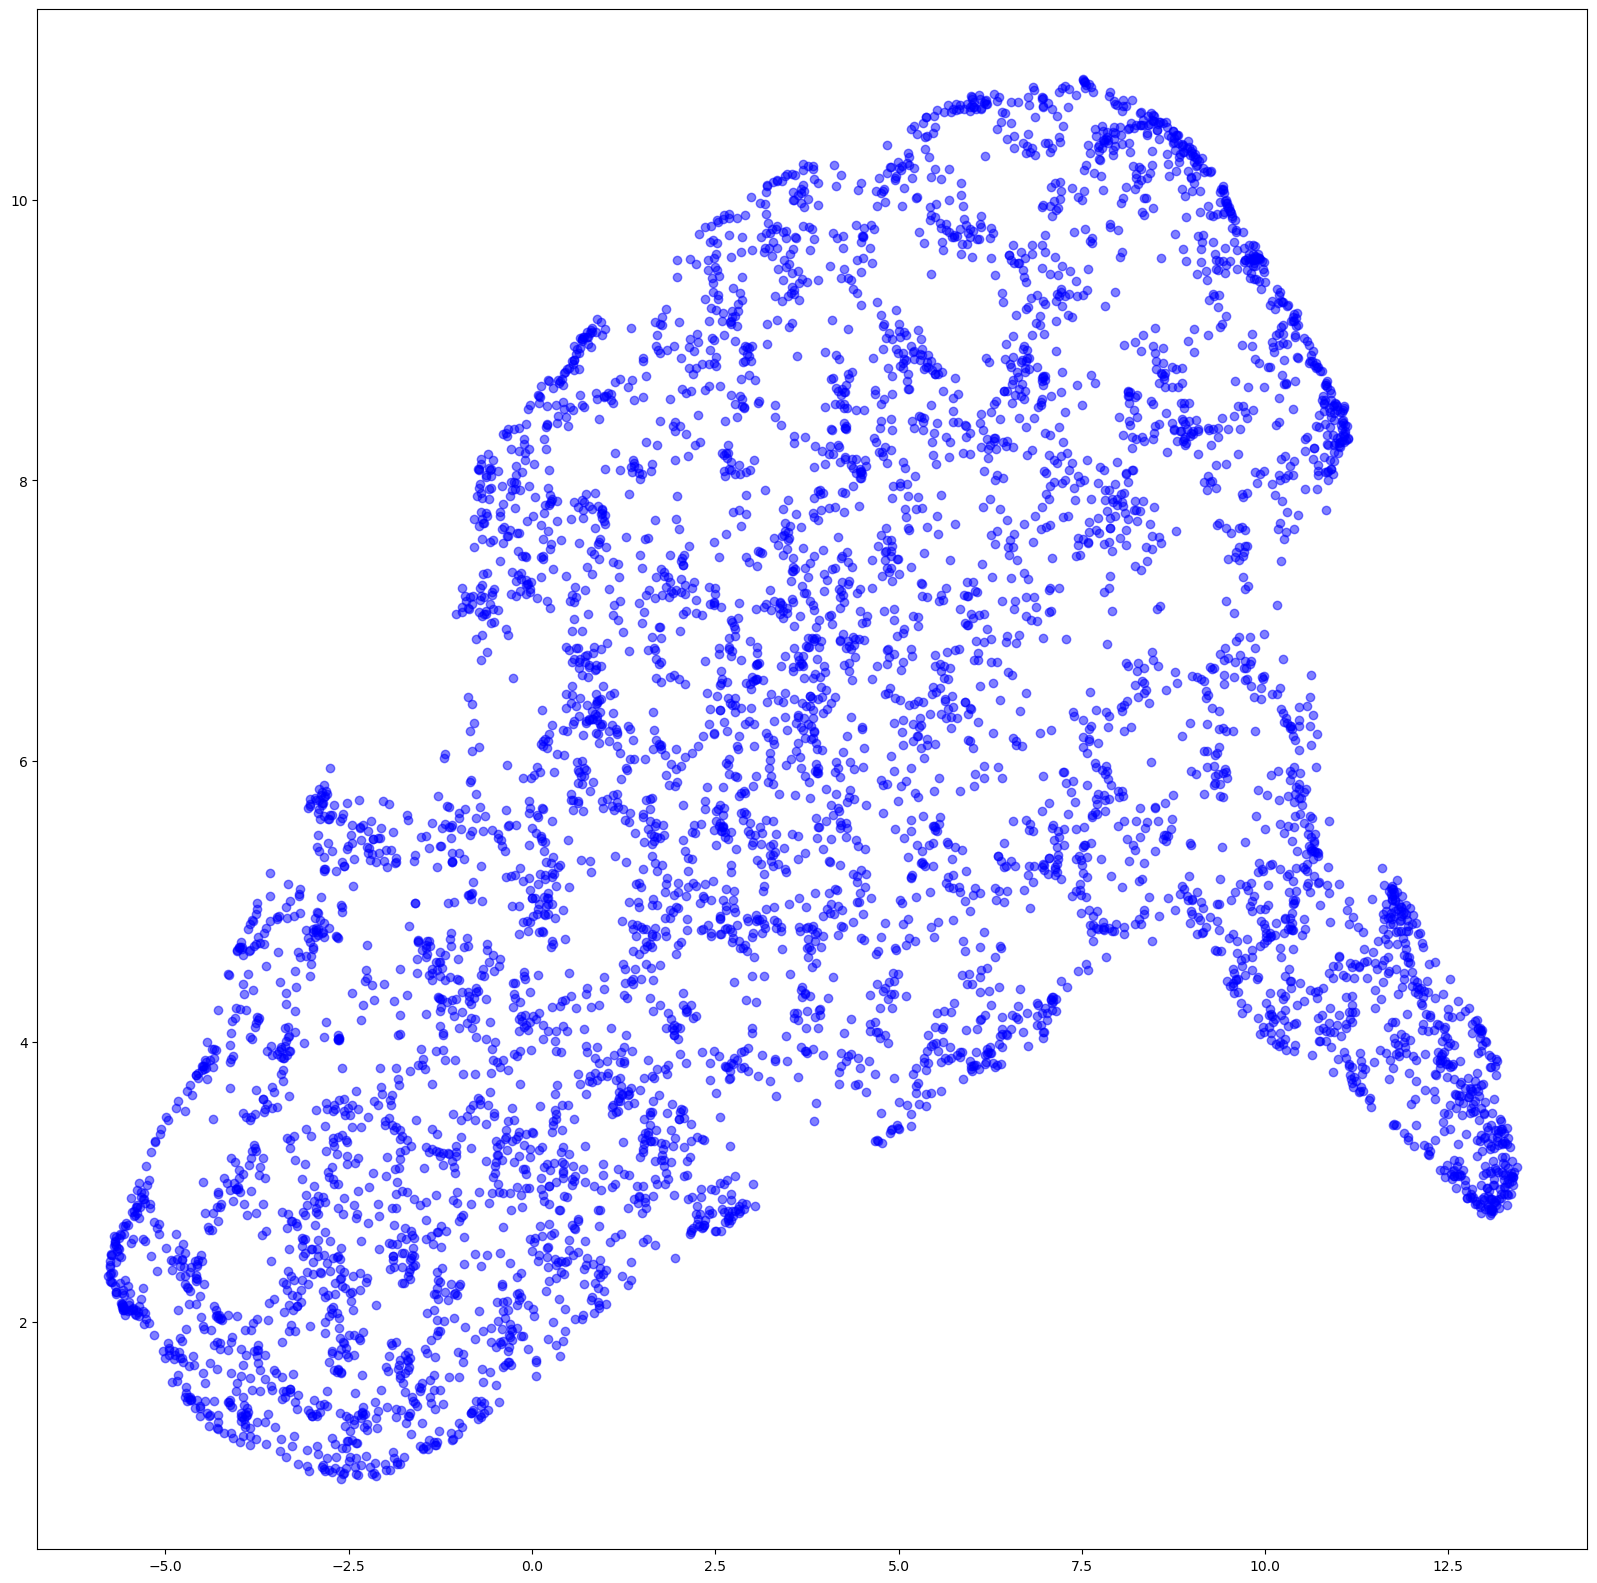

In [38]:
plt.figure(figsize = (20, 20))

#for i in range(filament_cluster_number):
#    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i)/filament_cluster_number), 
#                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
#plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.5,c='blue')
#plt.xlim((-2,20))
#plt.ylim((-7,10))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

In [39]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
start_index=11
#84
cluster_choice=umap_predict
positive_label=[]
cut_index=np.array(cut_index)
for i in range(len(helix_name)):
    if i in cut_index:
        t=np.count_nonzero(cut_index==i)
        while t>0:
            positive_label.append(helix_name[i][0][start_index:start_index+3])
            t-=1
    positive_label.append(helix_name[i][0][start_index:start_index+3])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
#labels_name=['type 3','type 1B','type 2B','type 1A','type 2A','type 2AB'] # define the type of filaments 
#labels_name=['singlet','doublet']
#labels_name=['1','2']
labels_name=['1','2','3','4','5']
#labels_name=['SF','PHF']
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(positive_label_new[2])
print(labels)

0.0
['190', '191']


In [40]:
helix_name[0]

('Extract/job190/Case2/FoilHole_24943300_Data_24944102_24944103_20190125_1833-129191.mrcs',
 0)

In [41]:
np.count_nonzero(cut_index==126)

0

6037


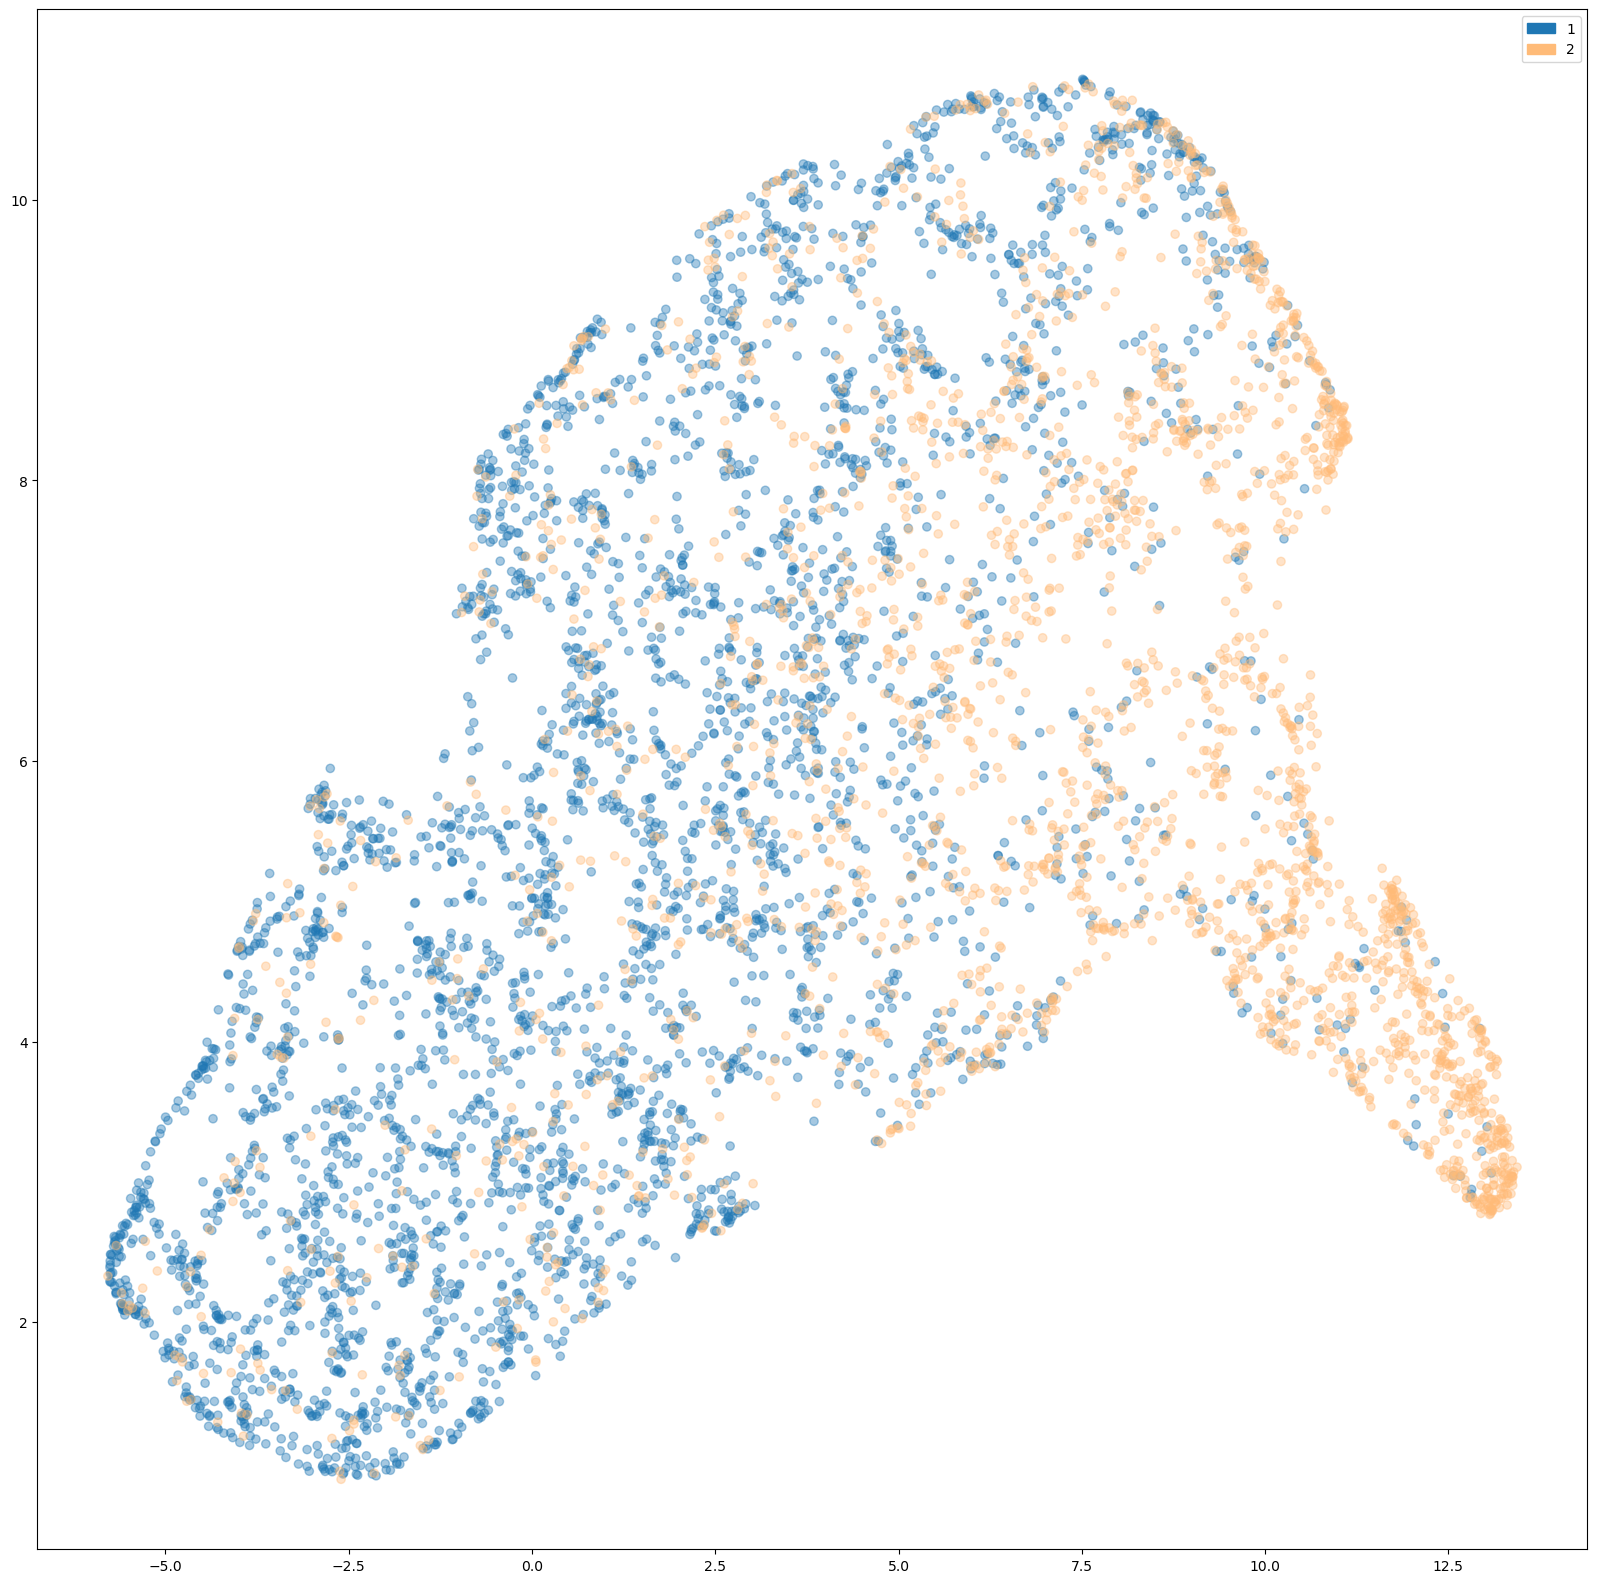

In [44]:
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/6), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
#plt.xlim((2,17))
#plt.ylim((0,15))
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/6),alpha=0.4)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_label_bert.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [ ]:
print(len(positive_label_new),len(cluster_choice))
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]
print(hist_data)
print(labels)

In [ ]:
#for i in range(0,filament_cluster_number):
#    distribution=[]
#    lst=hist_data[hist_data['predict']==i]
#    for j in range(len(labels)):
#        distribution.append(len(lst[lst['labels']==j])/len(lst))
#    distribution_hist_all.append(distribution)
#print(distribution_hist_all)

In [ ]:
#fig, ax = plt.subplots(1,filament_cluster_number,figsize = (5*filament_cluster_number,7))
#for i in range(filament_cluster_number):
#    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
#    particle_number=len(locals()['cluster'+str(i)])
#    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
#
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new_bert.png')
#plt.show()
#print('a')

In [ ]:
#fill corpus
corpus_fill=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(particle)
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle)
                    count+=1
                    break
                corpus_row+=[(0,count,0)]
                count+=1
    corpus_fill.append(corpus_row)
corpus_fill_cut,corpus_cut_index=cut_corpus(corpus_fill,block_size-2)

In [ ]:
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
#count=0    
for i in range(len(corpus_fill_cut)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus_fill_cut[i]
    for j in range(len(lst)):
        particle=lst[j]
        if particle[0]!=0:
            #count+=1
            dataline=particle[-1]
            locals()['cluster'+str(labels)].append(data[dataline])
number=0
for i in range(filament_cluster_number):
    cluster_number_count=len(locals()['cluster'+str(i)])
    print(i,cluster_number_count)
    number=number+cluster_number_count
print(number-len(data))

In [ ]:
# for input label
#for i in range(filament_cluster_number):
#    locals()['cluster'+str(i)]=[]
#    locals()['clusterID'+str(i)]=[]
#for i in range(len(corpus)):
#    labels=umap_predict[i]
#    locals()['clusterID'+str(labels)].append(i)
#    lst=corpus[i]
#    for j in range(len(lst)):
#        dataline=i+j
#        locals()['cluster'+str(labels)].append(data[dataline])

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/bert_'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()